In [7]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl

from Visualizations import SentinelVisualization
from models.PansharpeningUnetppLightning import PanSharpenUnetppLightning, denormalize, normalize
from SentinelData import SentinelCroppedDataset, SentinelDataset
from InteractiveVisualizations import InteractiveBandViewer
from ConfigParser import ConfigParser

visualization = SentinelVisualization("./dataset_sentinel", dataset= SentinelDataset("./dataset_sentinel"))
generator = torch.Generator().manual_seed(69)

# Testing & Profiling

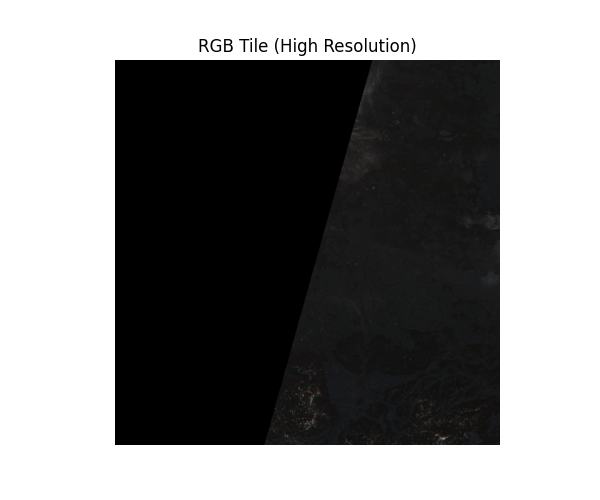

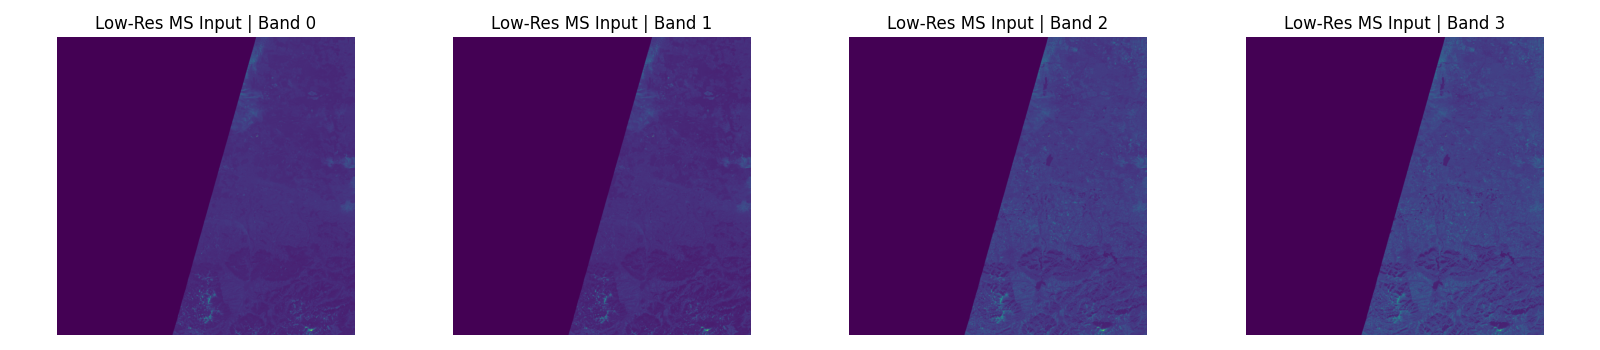

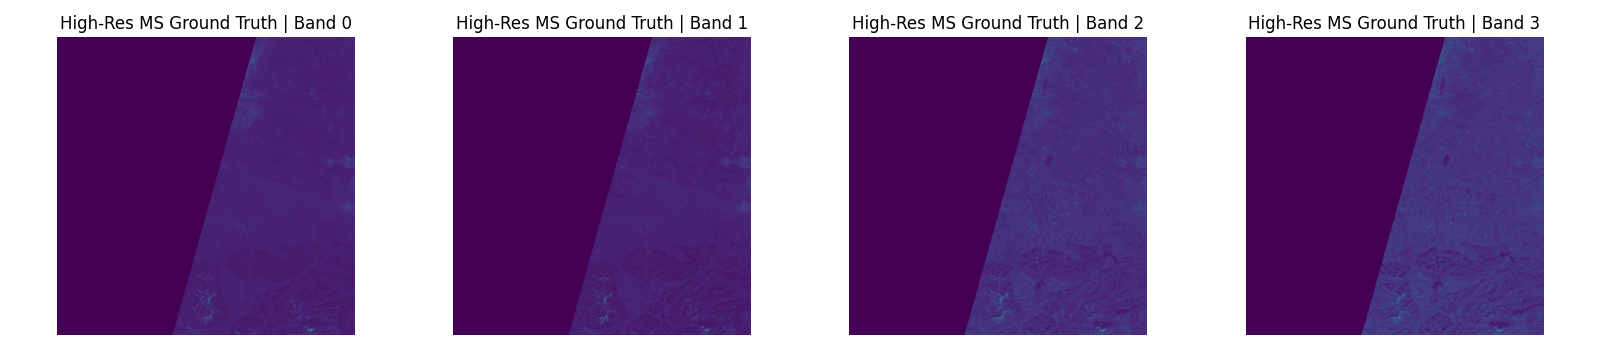

Displayed valid sample from val loader.


In [8]:
visualization.visualize_one_sample(
        loader_type="val",    # or "val" or "test"
    )

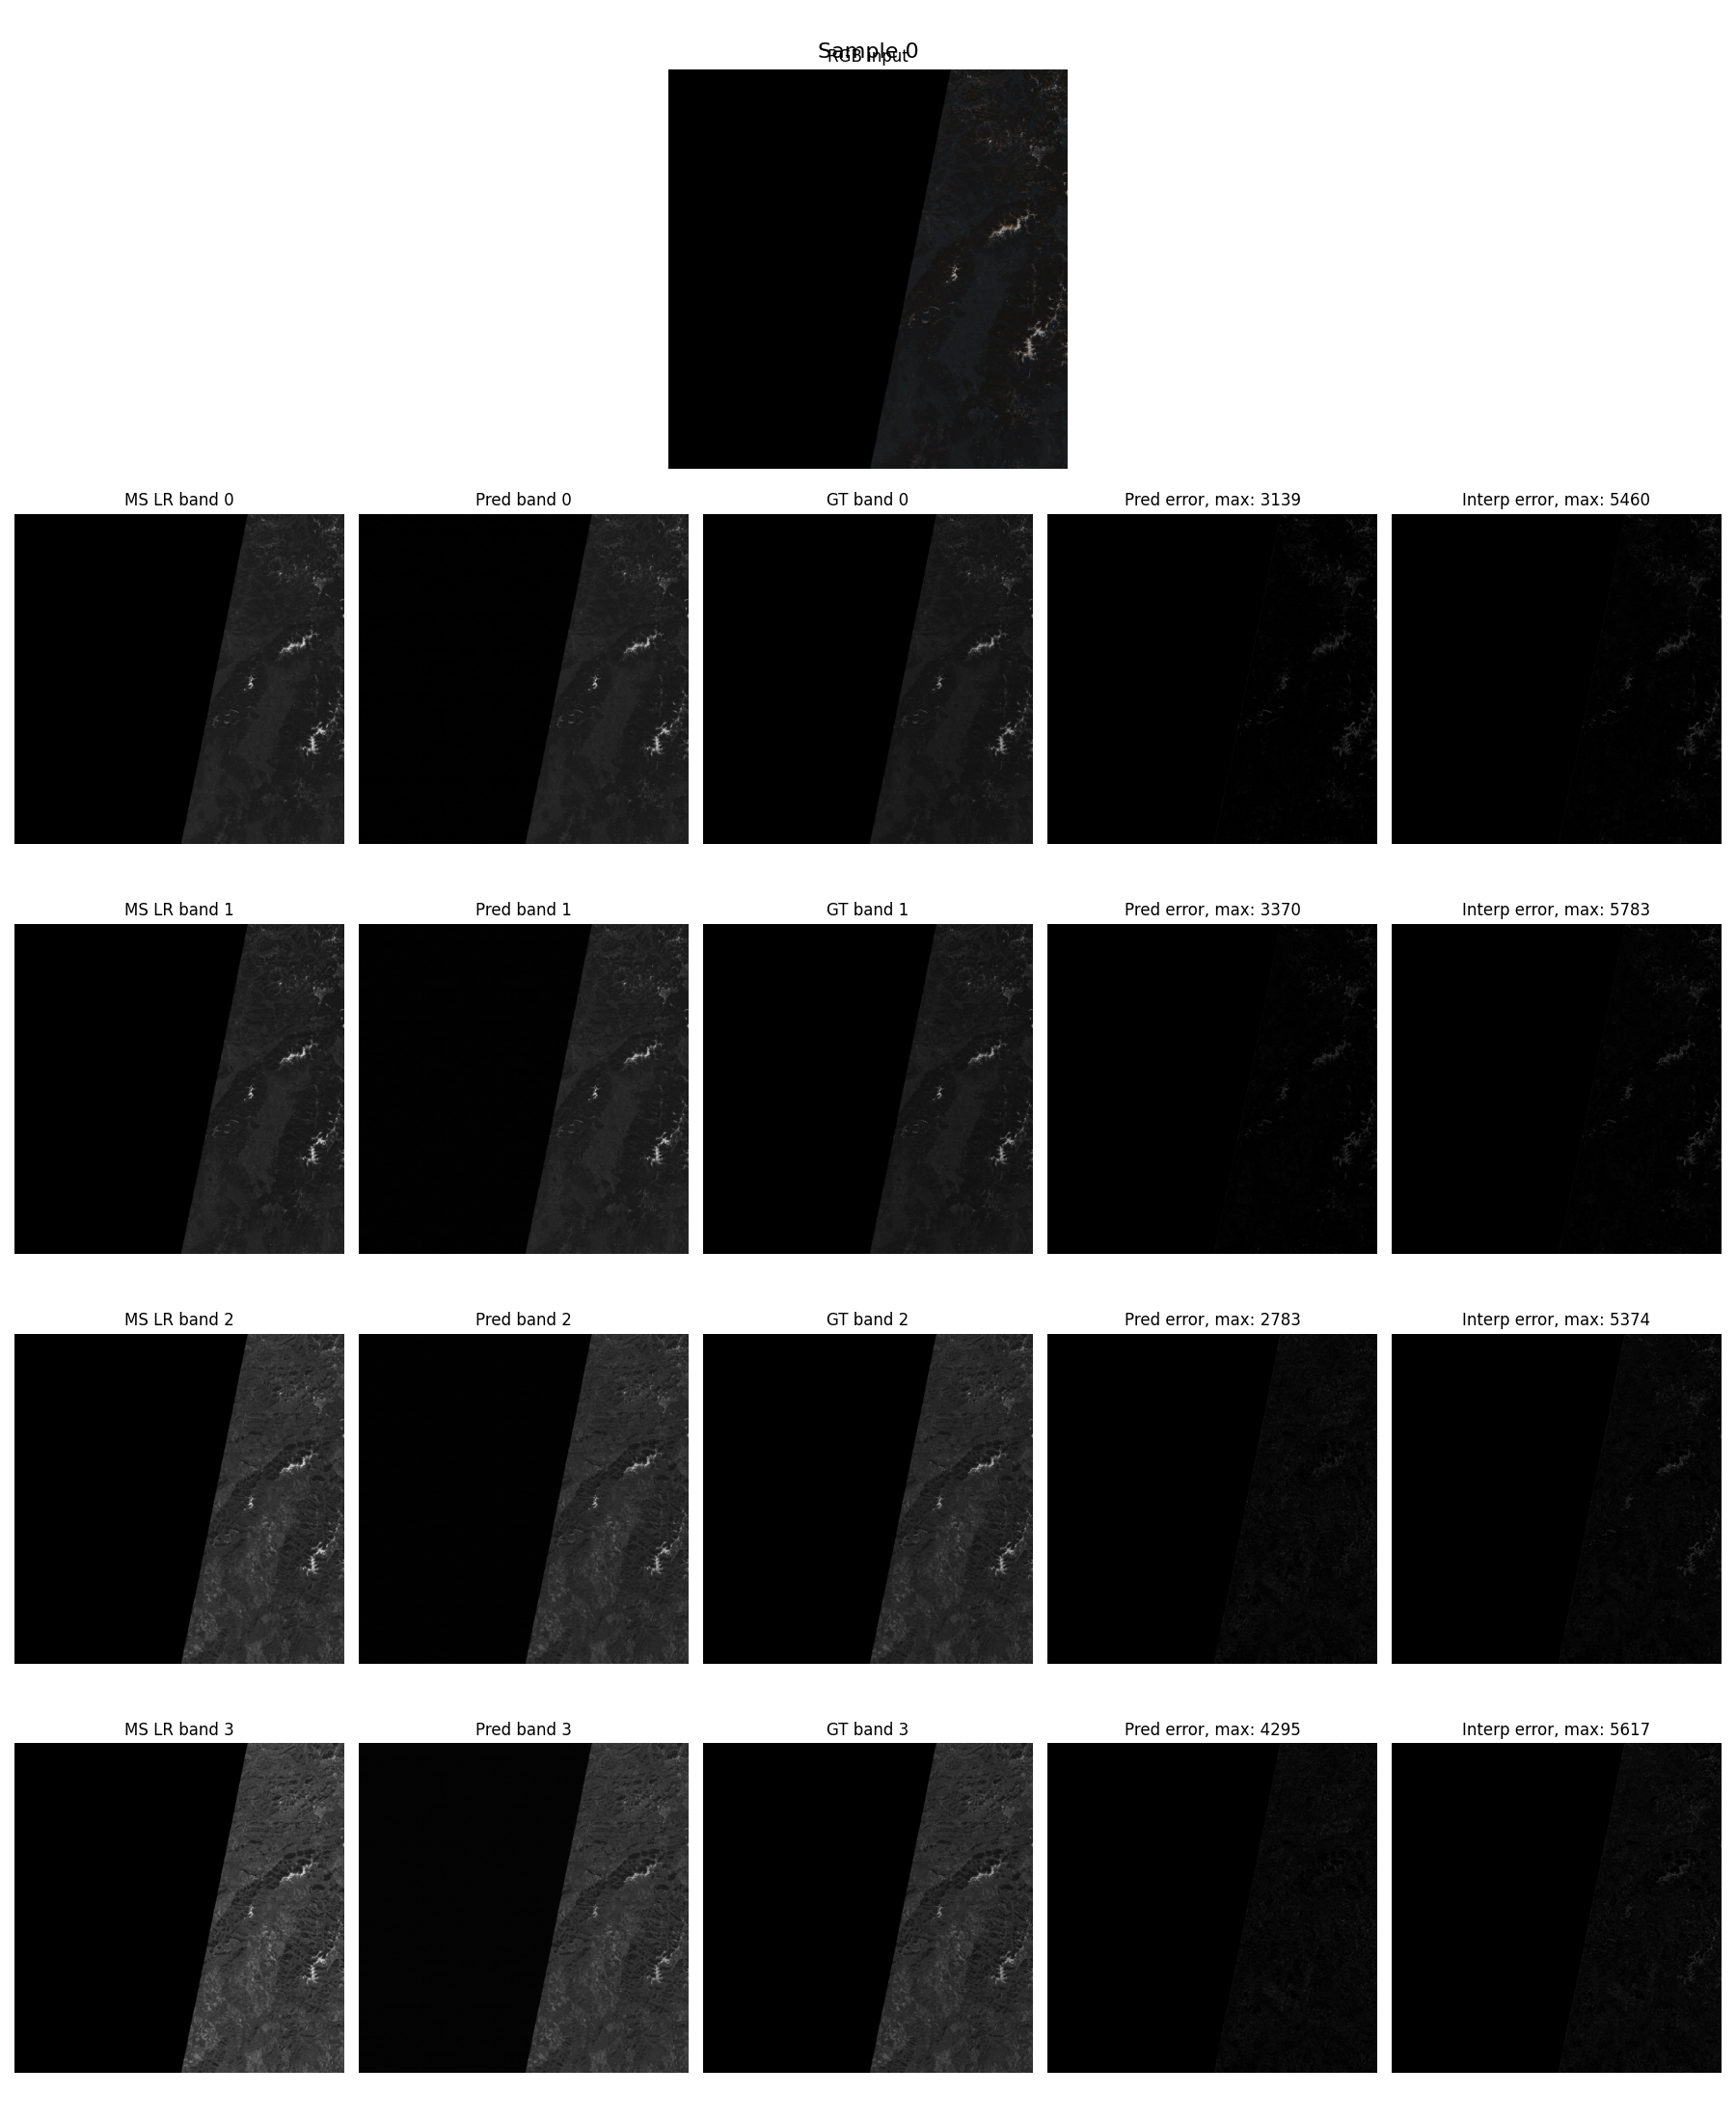

In [9]:
model = PanSharpenUnetppLightning.load_from_checkpoint("./saved_models/Unetpp_checkpoint/checkpoints/PanSharpenUnetppLightningTraining-drop-0.5-epoch=249-val_l1=0.0010.ckpt")


visualization.plot_pansharpen_bands(
    model=model,
    num_samples=5,
)

In [11]:

torch.set_float32_matmul_precision("high")

model.eval()  # explicit, though Lightning does this automatically

# ---- Dataset ----
config = ConfigParser()
dataset = SentinelCroppedDataset("./dataset_sentinel")
_, _, test_loader = dataset.produce_dataloaders(
    batch_size=config.get_training_batchsize()
)

# ---- Trainer ----
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision=32,
)

# ---- Test ----
trainer.test(model, dataloaders=test_loader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_input_mae       │   0.0024043116718530655   │
│      test_input_mse       │  1.8371627447777428e-05   │
│      test_input_psnr      │     47.3585205078125      │
│          test_l1          │   0.0014133898075670004   │
│         test_mae          │   0.0014133898075670004   │
│       test_mae_gain       │   0.000990921864286065    │
│         test_mse          │  6.0174284044478554e-06   │
│       test_mse_gain       │  1.2354199498076923e-05   │
│         test_psnr         │     52.20588684082031     │
│      test_psnr_gain       │    4.8473663330078125     │
└───────────────────────────┴───────────────────────────┘

[{'test_l1': 0.0014133898075670004,
  'test_mae': 0.0014133898075670004,
  'test_mse': 6.0174284044478554e-06,
  'test_psnr': 52.20588684082031,
  'test_input_mae': 0.0024043116718530655,
  'test_input_mse': 1.8371627447777428e-05,
  'test_input_psnr': 47.3585205078125,
  'test_psnr_gain': 4.8473663330078125,
  'test_mae_gain': 0.000990921864286065,
  'test_mse_gain': 1.2354199498076923e-05}]

In [14]:
dataset = SentinelDataset("./dataset_sentinel")
train_loader, val_loader, test_loader = dataset.produce_dataloaders(batch_size=32)
(rgb, ms_lr), ms_hr = next(iter(test_loader))
device = next(model.parameters()).device



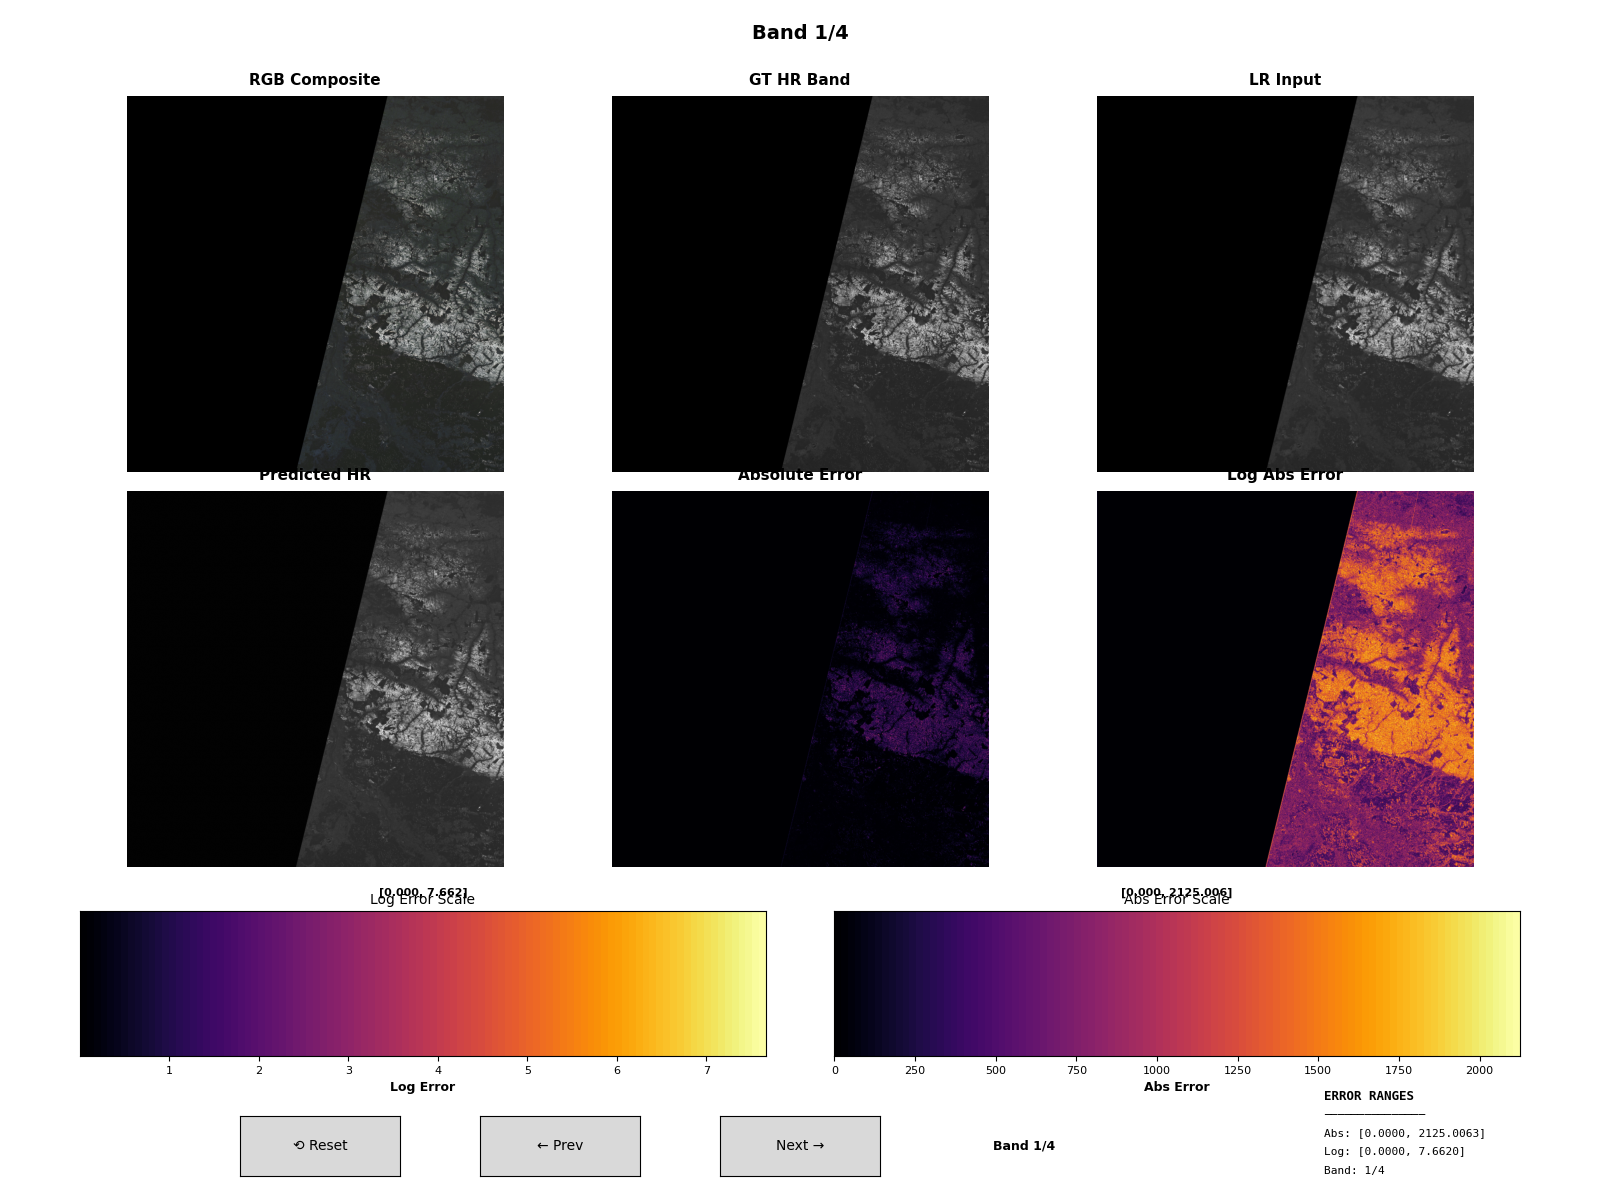

In [15]:
%matplotlib widget
(rgb, ms_lr), ms_hr = next(iter(train_loader))
with torch.no_grad():
    pred = denormalize(model(rgb.to(device), ms_lr.to(device))).cpu()


idx = 0  # choose sample
viewer = InteractiveBandViewer(
    ms_gt=ms_hr[idx],
    ms_pred=pred[idx],
    pan=rgb[idx],
    lr=ms_lr[idx],
    figsize=(16, 12)
)